In [1]:
import dill
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from tqdm.auto import trange

%matplotlib inline

/home/colm.talbot/.conda/envs/o4-population/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_mpl():
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Computer Modern Roman"
    mpl.rcParams["font.size"] = 20
    mpl.rcParams["text.usetex"] = True
    mpl.rcParams["grid.alpha"] = 0

    colorblind=["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC", "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"]
    mpl.rcParams["axes.prop_cycle"] = cycler(color=colorblind)

set_mpl()

In [5]:
import dill
import h5py

BASE_DIRECTORY = "/home/colm.talbot/O3/population/O3b/no_limits"


def load_spin_lines():
    with open(f"{BASE_DIRECTORY}/production_more_live/result/o1o2o3_IMR_mass_c_iid_spin_magnitude_mag_iid_spin_orientation_tilt_powerlaw_redshift_magnitude_data.h5", "rb") as ff:
        new_lines = dill.load(ff)["lines"]["a_1"]
    with open(f"{BASE_DIRECTORY}/production_more_injections_more_live/result/o1o2o3_IMR_mass_c_iid_spin_magnitude_mag_iid_spin_orientati_tilt_powerlaw_redshift_magnitude_data.h5", "rb") as ff:
        alt_lines = dill.load(ff)["lines"]["a_1"]
    keep = ~np.any(np.isinf(alt_lines), axis=-1)
    alt_lines = alt_lines[keep]
    with open(f"{BASE_DIRECTORY}/production_no_injections/result/o1o2o3_IMR_mass_c_iid_spin_magnitude_mag_iid_spin_orientati_tilt_powerlaw_redshift_magnitude_data.h5", "rb") as ff:
        no_lines = dill.load(ff)["lines"]["a_1"]
    keep = ~np.any(np.isinf(no_lines), axis=-1)
    no_lines = no_lines[keep]
    with h5py.File(f"/home/jacob.golomb/O3b/mar15/init/result/o1o2o3_IMR_mass_c_iid_mag_iid_tilt_powerlaw_redshift_magnitude_data.h5", "r") as ff:
        lvk_lines = ff["lines"]["a_1"][()]
    with open(f"{BASE_DIRECTORY}/n_events_scaling/tuned/result/69_mass_c_iid_spin_magnitude_mag_iid_spin_orientation_tilt_powerlaw_redshift_magnitude_data.h5", "rb") as ff:
        tuned_lines = dill.load(ff)["lines"]["a_1"]
    return new_lines, alt_lines, no_lines, lvk_lines, tuned_lines


def load_mass_lines():
    with open(f"{BASE_DIRECTORY}/production_more_live/result/o1o2o3_IMR_mass_c_iid_spin_magnitude_mag_iid_spin_orientati_tilt_powerlaw_redshift_mass_data.h5", "rb") as ff:
        new_lines = dill.load(ff)["lines"]["mass_1"]
    with open(f"{BASE_DIRECTORY}/production_more_injections_more_live/result/o1o2o3_IMR_mass_c_iid_spin_magnitude_mag_iid_spin_orientati_tilt_powerlaw_redshift_mass_data.h5", "rb") as ff:
        alt_lines = dill.load(ff)["lines"]["mass_1"] / 4
    with h5py.File(f"/home/jacob.golomb/O3b/mar15/init/result/o1o2o3_IMR_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5", "r") as ff:
        lvk_lines = ff["lines"]["mass_1"][()]
    with open(f"{BASE_DIRECTORY}/n_events_scaling/tuned/result/69_mass_c_iid_spin_magnitude_mag_iid_spin_orientation_tilt_powerlaw_redshift_mass_data.h5", "rb") as ff:
        tuned_lines = dill.load(ff)["lines"]["mass_1"] / 4
    return new_lines, alt_lines, lvk_lines, tuned_lines

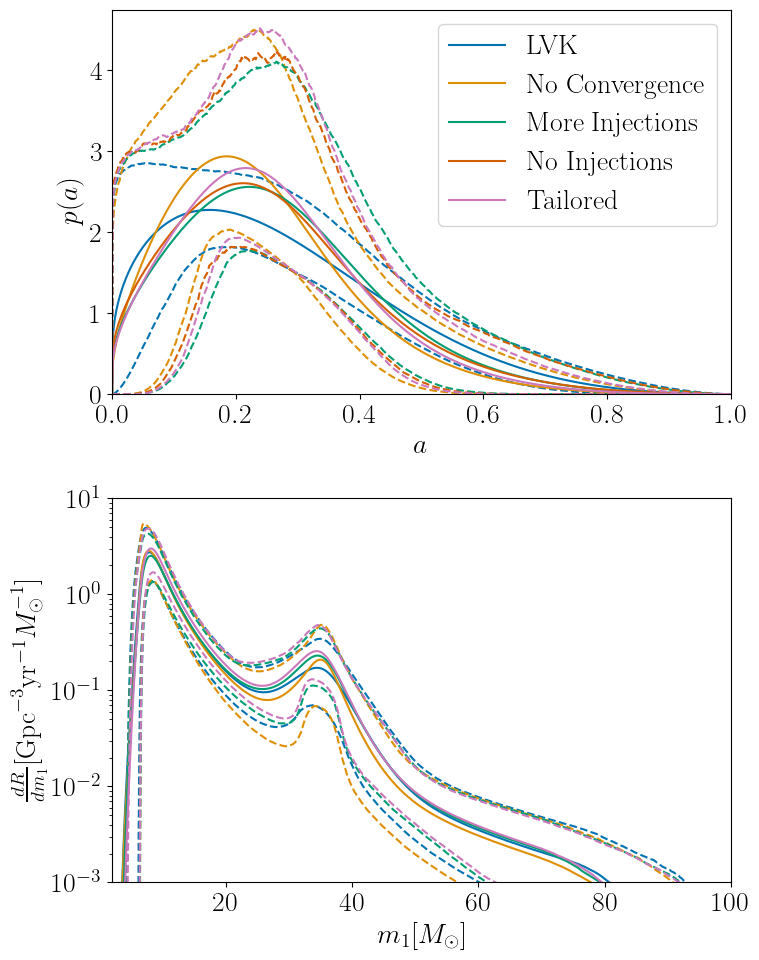

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))

plt.sca(axes[0])
new_lines, alt_lines, no_lines, lvk_lines, tuned_lines = load_spin_lines()
mags = np.linspace(0, 1, 1000)
mean_lines = list()
for lines, colour, label in zip(
    [lvk_lines, new_lines, alt_lines, no_lines, tuned_lines],
    ["C0", "C1", "C2", "C3", "C4"],
    ["LVK", "No Convergence", "More Injections", "No Injections", "Tailored"],
):
    lines /= np.trapz(lines, mags, axis=-1)[:, np.newaxis]
    plt.plot(mags, np.mean(lines, axis=0), color=colour, label=label)
    plt.plot(mags, np.percentile(lines, 5, axis=0), color=colour, linestyle="--")
    plt.plot(mags, np.percentile(lines, 95, axis=0), color=colour, linestyle="--")
    mean_lines.append(np.mean(lines, axis=0))
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel("$a$")
plt.ylabel("$p(a)$")
plt.legend(loc="upper right")

plt.sca(axes[1])
new_lines, alt_lines, lvk_lines, tuned_lines = load_mass_lines()
masses = np.linspace(2, 100, 1000)
mean_lines = list()
for lines, colour, label in zip(
    [lvk_lines, new_lines, alt_lines, tuned_lines],
    ["C0", "C1", "C2", "C4"],
    ["LVK", "No Convergence", "More Injections", "Tailored"],
):
    plt.plot(masses, np.mean(lines, axis=0), color=colour, label=label)
    plt.plot(masses, np.percentile(lines, 5, axis=0), color=colour, linestyle="--")
    plt.plot(masses, np.percentile(lines, 95, axis=0), color=colour, linestyle="--")
    mean_lines.append(np.mean(lines, axis=0))
plt.yscale("log")
plt.xlim(2, 100)
plt.ylim(1e-3, 1e1)
plt.xlabel("$m_{1} [M_{\\odot}]$")
plt.ylabel("$\\frac{dR}{d m_{1}} [{\\rm Gpc}^{-3}{\\rm yr}^{-1} M^{-1}_{\\odot}]$")

plt.tight_layout()
plt.savefig("figure-5.pdf")
plt.show()
plt.close()

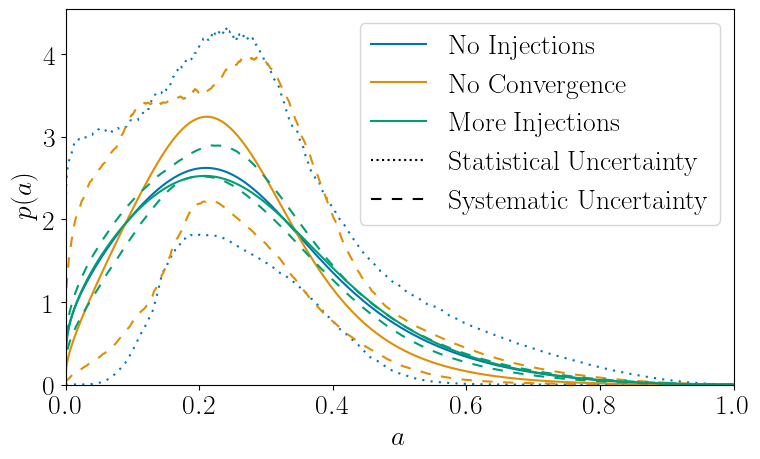

dict_keys(['ppd', 'alt_ppd', 'alt_curve', 'bounds', 'alt_bounds'])

In [8]:
data = np.load("/home/colm.talbot/O3/population/O3b/uncertainty/production/data.npz", allow_pickle=True)
data = {key: data[key] for key in data}
xvals = np.linspace(1e-5, 1 - 1e-5, 1000)

plt.figure(figsize=(8, 5))
plt.plot(xvals, data["ppd"], label="No Injections")
plt.plot(xvals, data["bounds"][:, 0], color=f"C{0}", linestyle=(0, (1, 3)))
plt.plot(xvals, data["bounds"][:, 1], color=f"C{0}", linestyle=(0, (1, 3)))
for ii, name in enumerate(["production", "more_injections", "tuned"][:-1]):
    data = np.load(f"/home/colm.talbot/O3/population/O3b/uncertainty/{name}/data.npz", allow_pickle=True)
    data = {key: data[key] for key in data}
    plt.plot(xvals, data["alt_ppd"], label=["No Convergence", "More Injections", "Tailored"][ii])
    plt.plot(xvals, data["alt_bounds"][:, 0], color=f"C{ii + 1}", linestyle=(0, (5, 5)))
    plt.plot(xvals, data["alt_bounds"][:, 1], color=f"C{ii + 1}", linestyle=(0, (5, 5)))
plt.axvline(-1, label="Statistical Uncertainty", linestyle=":", color="k")
plt.axvline(-1, label="Systematic Uncertainty", linestyle=(0, (5, 5)), color="k")

plt.xlim(0, 1)
plt.ylim(0)

plt.xlabel("$a$")
plt.ylabel("$p(a)$")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("figure-6.pdf")
plt.show()
plt.close()